In [16]:
## imports
import pandas as pd
import numpy as np
import re
import requests
import yaml
import matplotlib.pyplot as plt

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. Example 1: no credentials; no wrapper

Site: National Assessment of Education Progress (NAEP)

Documentation: https://www.nationsreportcard.gov/api_documentation.aspx

Base link: https://www.nationsreportcard.gov/DataService/GetAdhocData.aspx 

## 1.1 Query to pull some data

In [2]:
## using their example query of 2011 writing scores separated by gender
## based on here - https://stackoverflow.com/questions/40836749/pythonic-way-of-writing-a-single-line-long-string
## using the ( ) syntax to formulate a long
## string without linebreaks added
example_naep_query = (
    'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?'
    'type=data&subject=writing&grade=8&'
    'subscale=WRIRP&variable=GENDER&jurisdiction=NP&stattype=MN:MN&Year=2011'
)

example_naep_query

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=writing&grade=8&subscale=WRIRP&variable=GENDER&jurisdiction=NP&stattype=MN:MN&Year=2011'

In [18]:
## use requests to call the api
naep_resp = requests.get(example_naep_query)
naep_resp
print(type(naep_resp))

## get the json contents of the response 
## here, we're assuming valid response
naep_resp_j = naep_resp.json()
naep_resp_j

## with result, turn it into a dataframe
naep_resp_d = pd.DataFrame(naep_resp_j['result'])
naep_resp_d

<Response [200]>

<class 'requests.models.Response'>


{'status': 200,
 'serviceVersion': '10.24.2025.2',
 'dwellTimeMS': '4864.2501',
 'avgWebHostCPUTotalLoad': 'N/A',
 'dataHitType': 'FROM_DATABASE',
 'Source': 'B11A',
 'result': [{'year': 2011,
   'sample': 'R3',
   'yearSampleLabel': '2011',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'WRI',
   'grade': 8,
   'scale': 'WRIRP',
   'jurisdiction': 'NP',
   'jurisLabel': 'National public',
   'variable': 'GENDER',
   'variableLabel': 'Sex',
   'varValue': '1',
   'varValueLabel': 'Male',
   'value': 139.099504632971,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2011,
   'sample': 'R3',
   'yearSampleLabel': '2011',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'WRI',
   'grade': 8,
   'scale': 'WRIRP',
   'jurisdiction': 'NP',
   'jurisLabel': 'National public',
   'variable': 'GENDER',
   'variableLabel': 'Sex',
   'varValue': '2',
   'varValueLabel': 'Female',
   'value': 158.567104984955,
   'isSta

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2011,R3,2011,2,Grade 8,MN:MN,WRI,8,WRIRP,NP,National public,GENDER,Sex,1,Male,139.099505,1,0
1,2011,R3,2011,2,Grade 8,MN:MN,WRI,8,WRIRP,NP,National public,GENDER,Sex,2,Female,158.567105,1,0


### Wrap your long URL into a shorter version using the `params` argument

In [6]:
base_url = "https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx"

params = {
    "type": "data",
    "subject": "writing",
    "grade": "8",
    "subscale": "WRIRP",
    "variable": "GENDER",
    "jurisdiction": "NP",
    "stattype": "MN:MN",
    "Year": "2011"
}

response = requests.get(base_url, params=params)

print(response.url)

https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=writing&grade=8&subscale=WRIRP&variable=GENDER&jurisdiction=NP&stattype=MN%3AMN&Year=2011


In [7]:
response

<Response [200]>

In [8]:
pd.DataFrame(response.json()['result'])

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2011,R3,2011,2,Grade 8,MN:MN,WRI,8,WRIRP,NP,National public,GENDER,Sex,1,Male,139.099505,1,0
1,2011,R3,2011,2,Grade 8,MN:MN,WRI,8,WRIRP,NP,National public,GENDER,Sex,2,Female,158.567105,1,0


## 1.2 What happens if there's an error in our query?

In [7]:
## here's a query that from the documentation we know
## won't work since i modified year to 2025 which doesnt
## exist in the data
wrong_naep_query = (
    'https://www.nationsreportcard.gov/'
    'Dataservice/GetAdhocData.aspx?'
    'type=data&subject=writing&grade=8&'
    'subscale=WRIRP&variable=GENDER&jurisdiction=NP&stattype=MN:MN&Year=2025'
)

wrong_naep_query

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=writing&grade=8&subscale=WRIRP&variable=GENDER&jurisdiction=NP&stattype=MN:MN&Year=2025'

In [8]:
## use requests to call the api
naep_wrong_resp = requests.get(wrong_naep_query)
naep_wrong_resp

<Response [400]>

In [9]:
## in the case of this particular api,
## the call returns some response but
## when we try to extract the json containing
## status or results, we get in an error
naep_wrong_resp.json() # uncomment to see error

JSONDecodeError: Invalid control character at: line 1 column 293 (char 292)

### 1.2.2 More all-purpose way of allowing remainder of calls to run: try, except

In [10]:
## putting it in a try; except as general error catching
try:
    results = naep_wrong_resp.json()['result']
except Exception as e:
    print('Failed to get result from API due to error:')
    print(e) # or just: pass

Failed to get result from API due to error:
Invalid control character at: line 1 column 293 (char 292)


### 1.2.3 Can usually also find more targeted way but that varies more across APIs

In [11]:
## if we wanted do more specific error catching,
## see that the status == 400 actually appears here
## so could write if else along those lines
naep_wrong_resp.text
naep_resp.text

if "System.Exception" in naep_wrong_resp.text:
    print("NAEP results not found")

'{"statusCode":400,"result": "System.Exception: The query \'SELECT DISTINCT Framework FROM Cycles WHERE Subject=\'WRI\' AND Cohort=2 AND CONVERT(VARCHAR(10),Year)+Sample IN (\'2025R3\')\' did not return exactly 1 framework. Make sure you can trend the years defined for the given subject and cohort.\r\n   at NRCDataService3.GetAdhocData.GetFramework(NDEContext& ndeContext, String subjectCode, List`1 yearSamples, String cohort) in C:\\projects\\ndecore2025\\NRCDataService2\\GetAdhocData.aspx.cs:line 2701\r\n   at NRCDataService3.GetAdhocData.PopulateBaseOrchestratorRequest() in C:\\projects\\ndecore2025\\NRCDataService2\\GetAdhocData.aspx.cs:line 2322\r\n   at NRCDataService3.GetAdhocData.ConstructRequest_Datapoint() in C:\\projects\\ndecore2025\\NRCDataService2\\GetAdhocData.aspx.cs:line 920\r\n   at NRCDataService3.GetAdhocData.Page_Load(Object sender, EventArgs e) in C:\\projects\\ndecore2025\\NRCDataService2\\GetAdhocData.aspx.cs:line 346"}'

'{"status":200,"serviceVersion":"8.28.2025.1","dwellTimeMS":"375.0087","avgWebHostCPUTotalLoad":"N/A","dataHitType":"FROM_DATABASE","Source":"B11B","result": [{"year":2011,"sample":"R3","yearSampleLabel":"2011","Cohort":2,"CohortLabel":"Grade 8","stattype":"MN:MN","subject":"WRI","grade":8,"scale":"WRIRP","jurisdiction":"NP","jurisLabel":"National public","variable":"GENDER","variableLabel":"Sex","varValue":"1","varValueLabel":"Male","value":139.099504632971,"isStatDisplayable":1,"errorFlag":0},{"year":2011,"sample":"R3","yearSampleLabel":"2011","Cohort":2,"CohortLabel":"Grade 8","stattype":"MN:MN","subject":"WRI","grade":8,"scale":"WRIRP","jurisdiction":"NP","jurisLabel":"National public","variable":"GENDER","variableLabel":"Sex","varValue":"2","varValueLabel":"Female","value":158.567104984955,"isStatDisplayable":1,"errorFlag":0}]}'

NAEP results not found


## Activity 1: writing a function to make multiple, sequential calls

- Say we want to pull the data for grades 4, 8, and 12
- How can we write a function that iterates over a list of those grades and pulls the data for each grade?

**Note**: an ideal function would have arguments for each parameter in the API like subject, subscale, etc. Here we can leave those other parts constant

In [12]:
base_url = "https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx"

default_params = {
    "type": "data",
    "subject": "writing",
    "subscale": "WRIRP",
    "variable": "GENDER",
    "jurisdiction": "NP",
    "stattype": "MN:MN",
    "Year": "2011"
}

def naep_api_calls(base_url, grades, params):
    
    dflist = []

    for grade in grades:
        
        params = default_params
        params['grade'] = grade
        
        naep_resp = requests.get(base_url, params=params)
        
        try:
            naep_resp_df = pd.DataFrame(naep_resp.json()['result'])
            dflist.append(naep_resp_df)
        except Exception as e:
            print("Failed to get result from API for grade {} due to error:".format(str(grade)))
            print(e)
        
    combined_result_df = pd.concat(dflist)
    
    return(combined_result_df)

naep_api_calls(
    base_url, 
    grades = [4,8,12], 
    params = default_params
)

Failed to get result from API for grade 4 due to error:
Invalid control character at: line 1 column 293 (char 292)


,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2011,R3,2011,2,Grade 8,MN:MN,WRI,8,WRIRP,NP,National public,GENDER,Sex,1,Male,139.099505,1,0
1,2011,R3,2011,2,Grade 8,MN:MN,WRI,8,WRIRP,NP,National public,GENDER,Sex,2,Female,158.567105,1,0
0,2011,R3,2011,3,Grade 12,MN:MN,WRI,12,WRIRP,NP,National public,GENDER,Sex,1,Male,141.256978,1,0
1,2011,R3,2011,3,Grade 12,MN:MN,WRI,12,WRIRP,NP,National public,GENDER,Sex,2,Female,155.385917,1,0


# 2. Example 2: needs credentials; no wrapper

Create an account here: https://site.financialmodelingprep.com/

In [9]:
## get the key
API_KEY = "1u9OsSM7lc7t2wnk1tfjdbWl4BRGFmze"

# Activity 2: Plot historical stock prices for a given company

- Look up the documentation: https://site.financialmodelingprep.com/developer/docs
- Find how you can get historical stock prices for a given company ticker symbol
- Write a function that takes in a ticker symbol and an API key and returns a DataFrame with the historical stock prices for that company
- Plot the closing prices over time for a NVIDIA, ticker symbol `NVDA`

In [19]:
base_url = "https://financialmodelingprep.com/stable/historical-price-eod/full"
COMPANY = "NVDA"

params = {
    "apikey": API_KEY,
    "symbol": COMPANY
}

response = requests.get(base_url, params=params)

In [20]:
response

<Response [200]>

In [21]:
response.json()

[{'symbol': 'NVDA',
  'date': '2026-02-03',
  'open': 186.235,
  'high': 186.24,
  'low': 176.23,
  'close': 180.32,
  'volume': 195709427,
  'change': -5.92,
  'changePercent': -3.17609,
  'vwap': 180.93},
 {'symbol': 'NVDA',
  'date': '2026-02-02',
  'open': 187.2,
  'high': 190.3,
  'low': 184.88,
  'close': 185.61,
  'volume': 165794054,
  'change': -1.59,
  'changePercent': -0.84936,
  'vwap': 186.9975},
 {'symbol': 'NVDA',
  'date': '2026-01-30',
  'open': 191.21,
  'high': 194.49,
  'low': 189.47,
  'close': 191.13,
  'volume': 179489500,
  'change': -0.08,
  'changePercent': -0.04183882,
  'vwap': 191.575},
 {'symbol': 'NVDA',
  'date': '2026-01-29',
  'open': 191.34,
  'high': 193.48,
  'low': 186.06,
  'close': 192.51,
  'volume': 171764400,
  'change': 1.17,
  'changePercent': 0.61148,
  'vwap': 190.8475},
 {'symbol': 'NVDA',
  'date': '2026-01-28',
  'open': 191.27,
  'high': 192.35,
  'low': 189.84,
  'close': 191.52,
  'volume': 148552700,
  'change': 0.25,
  'changePerce

In [22]:
price_df = pd.DataFrame(response.json())
price_df

,symbol,date,open,high,low,close,volume,change,changePercent,vwap
0,NVDA,2026-02-03,186.235,186.24,176.23,180.32,195709427,-5.920000,-3.176090,180.9300
1,NVDA,2026-02-02,187.200,190.30,184.88,185.61,165794054,-1.590000,-0.849360,186.9975
2,NVDA,2026-01-30,191.210,194.49,189.47,191.13,179489500,-0.080000,-0.041839,191.5750
3,NVDA,2026-01-29,191.340,193.48,186.06,192.51,171764400,1.170000,0.611480,190.8475
4,NVDA,2026-01-28,191.270,192.35,189.84,191.52,148552700,0.250000,0.130710,191.2450
...,...,...,...,...,...,...,...,...,...,...
1250,NVDA,2021-02-10,14.460,14.91,14.34,14.76,485352320,0.301000,2.070000,14.6175
1251,NVDA,2021-02-09,14.340,14.58,14.22,14.26,287560120,-0.077375,-0.557880,14.3500
1252,NVDA,2021-02-08,13.730,14.47,13.73,14.44,434624000,0.711540,5.170000,14.0925
1253,NVDA,2021-02-05,13.730,13.74,13.55,13.59,169153640,-0.134000,-1.020000,13.6525


In [23]:
price_df['date'] = pd.to_datetime(price_df['date'])
price_df = price_df.sort_values('date')
price_df

,symbol,date,open,high,low,close,volume,change,changePercent,vwap
1254,NVDA,2021-02-04,13.530,13.67,13.34,13.66,201340000,0.133250,0.960830,13.5500
1253,NVDA,2021-02-05,13.730,13.74,13.55,13.59,169153640,-0.134000,-1.020000,13.6525
1252,NVDA,2021-02-08,13.730,14.47,13.73,14.44,434624000,0.711540,5.170000,14.0925
1251,NVDA,2021-02-09,14.340,14.58,14.22,14.26,287560120,-0.077375,-0.557880,14.3500
1250,NVDA,2021-02-10,14.460,14.91,14.34,14.76,485352320,0.301000,2.070000,14.6175
...,...,...,...,...,...,...,...,...,...,...
4,NVDA,2026-01-28,191.270,192.35,189.84,191.52,148552700,0.250000,0.130710,191.2450
3,NVDA,2026-01-29,191.340,193.48,186.06,192.51,171764400,1.170000,0.611480,190.8475
2,NVDA,2026-01-30,191.210,194.49,189.47,191.13,179489500,-0.080000,-0.041839,191.5750
1,NVDA,2026-02-02,187.200,190.30,184.88,185.61,165794054,-1.590000,-0.849360,186.9975


<Figure size 640x480 with 0 Axes>

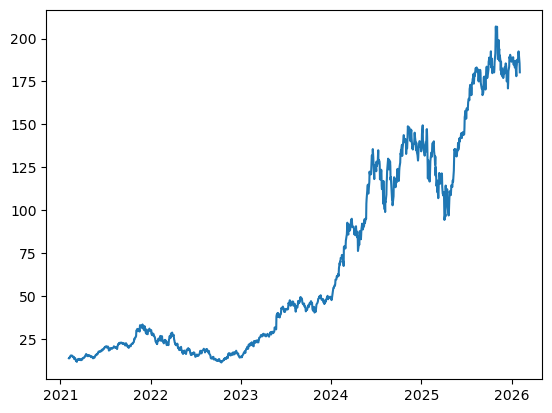

In [24]:
plt.figure()
plt.plot(price_df['date'], price_df['close'])
plt.show()